In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import math

In [221]:
dateparse = lambda dates: pd.datetime.strptime(dates,'%Y-%m-%d %H:%M:%S')
data = pd.read_csv("../Prashant July/formatted_cpu_data_for_R_forecasting_5min.csv",sep = ',',index_col='timestamp',date_parser=dateparse)


In [222]:
datum = data.values
datum = datum.astype('float32')

train = datum[0:100, :]
test= datum[100:, :]



In [223]:
#creating the data
def prepare_data(datum, lags = 1):
    """
    Creating lagged data from an input series
    """
    X,y = [], []
    for row in range(len(datum) - lags - 1):
        a = datum[row:(row + lags), 0]
        X.append(a)
        y.append(datum[row+lags, 0])
        
    return np.array(X), np.array(y)

# ANN with window i.e look back windows

In [167]:
lags = 2
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)
y_true = y_test 


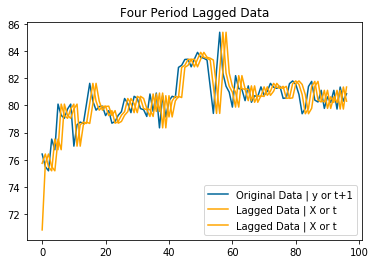

In [168]:
plt.plot(y_train, label='Original Data | y or t+1', color='#006699')
plt.plot(X_train, label='Lagged Data | X or t', color='orange')
plt.legend(loc='best')
plt.title('Four Period Lagged Data')
plt.show()

In [169]:
mlp = Sequential()
mlp.add(Dense(6,input_dim=lags, activation='relu'))
mlp.add(Dense(8, activation ='relu'))
mlp.add(Dense(1))
mlp.compile(loss='mean_squared_error', optimizer='adam')
mlp.fit(X_train, y_train, epochs = 400, batch_size=2, verbose = 0)

In [170]:
train_score = mlp.evaluate(X_train, y_train, verbose = 0)
print('Train Score: {:.2f} MSE ({:.2f} RMSE)'.format(train_score, math.sqrt(train_score)))
test_score = mlp.evaluate(X_test, y_test, verbose=0)
print('Test Score: {:.2f} MSE ({:.2f} RMSE)'.format(test_score, math.sqrt(test_score)))

Train Score: 1.52 MSE (1.23 RMSE)
Test Score: 3.39 MSE (1.84 RMSE)


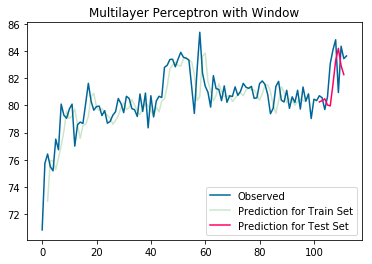

In [171]:
train_predict = mlp.predict(X_train)
test_predict = mlp.predict(X_test)
 
# shift train predictions for plotting
train_predict_plot = np.empty_like(datum)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags: len(train_predict) + lags, :] = train_predict
 
# shift test predictions for plotting
test_predict_plot = np.empty_like(datum)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(lags*2)+1:len(datum)-1, :] = test_predict
 
# plot baseline and predictions
plt.plot(datum, label='Observed', color='#006699');
plt.plot(train_predict_plot, label='Prediction for Train Set', color='green', alpha=0.2);
plt.plot(test_predict_plot, label='Prediction for Test Set', color='#ff0066');
plt.legend(loc='best');
plt.title('Multilayer Perceptron with Window')
plt.show()

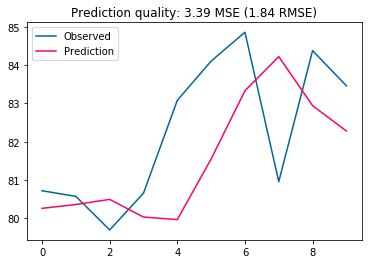

In [173]:
mse = ((y_test.reshape(-1, 1) - test_predict.reshape(-1, 1)) ** 2).mean()
plt.title('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))
plt.plot(y_test.reshape(-1, 1), label='Observed', color='#006699')
plt.plot(test_predict.reshape(-1, 1), label='Prediction', color='#ff0066')
plt.legend(loc='best');
plt.show()

# LSTM Recurrent Neural Network

In [224]:
lstm_data = datum
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(datum)

Ltrain = dataset[0:100,:]
Ltest = dataset[100:,:]

In [225]:
lstm_lags = 3
X_train, y_train = prepare_data(Ltrain, lstm_lags)
X_test, y_test = prepare_data(Ltest, lstm_lags)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [226]:
X_train.shape
#y_train.shape

(96, 1, 3)

In [227]:
mdl = Sequential()
mdl.add(Dense(3, input_shape=(1, lstm_lags), activation='relu'))
mdl.add(LSTM(6, activation='relu'))
mdl.add(Dense(1, activation='relu'))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=400, batch_size=1, verbose=0)
mdl.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 1, 3)              12        
_________________________________________________________________
lstm_12 (LSTM)               (None, 6)                 240       
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 7         
Total params: 259
Trainable params: 259
Non-trainable params: 0
_________________________________________________________________


In [228]:
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)
 
# invert transformation
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
 
# calculate root mean squared error
#train_score = math.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
#print('Train Score: {:.2f} RMSE'.format(train_score))
#test_score = math.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
#print('Test Score: {:.2f} RMSE'.format(test_score))




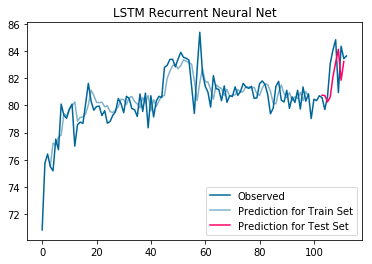

In [229]:
train_predict_plot = np.empty_like(lstm_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lstm_lags:len(train_predict)+lstm_lags, :] = train_predict
 
# shift test predictions for plotting
test_predict_plot = np.empty_like(lstm_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (lstm_lags * 2)+1:len(lstm_data)-1, :] = test_predict
 
# plot observation and predictions
plt.plot(lstm_data, label='Observed', color='#006699');
plt.plot(train_predict_plot, label='Prediction for Train Set', color='#006699', alpha=0.5);
plt.plot(test_predict_plot, label='Prediction for Test Set', color='#ff0066');
plt.legend(loc='best')
plt.title('LSTM Recurrent Neural Net')
plt.show()

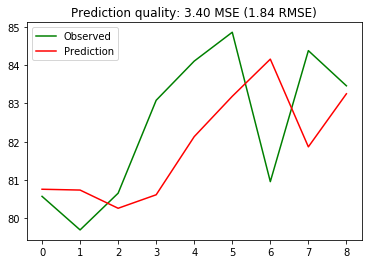

In [230]:
mse = ((y_test.reshape(-1, 1) - test_predict.reshape(-1, 1)) ** 2).mean()
plt.title('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))
plt.plot(y_test.reshape(-1, 1), label='Observed', color='green')
plt.plot(test_predict.reshape(-1, 1), label='Prediction', color='red')
plt.legend(loc='upper left');
plt.savefig('../Prashant July/lstm_close.png')
plt.show()